# 卷积神经网络（CNN）基础知识

## 卷积层
卷积层通过卷积核在输入图片的张量上滑动，，然后缩小到另一个张量，进行提取特征，一般是用一个比较小的卷积核，多层进行提取特征。
因为卷积核化冻之后得到的张量小很多，所以需要进行边缘填充，都填充0，保证和原来的输入一样大（可以不填充）
## 非线性变化层，
其实就是激活函数，保证神经网络非线性
## 池化层
池化层也对应一个池化核，主要就是进行降维，以免神经网络的计算量太大，比如说选取的是最大池化核，假如这个池化核是2*2的那么就是在这个2*2的四个像素中选取一个数值最大的像素留下来。4*4 变成 2*2
## 全连接层
因为不同的卷积核提取的特征不一样，有的对边缘特征敏感，有的对眼睛，耳朵敏感，全连接层就是将这些特征全部连接在一块，通过全部的特征来进行分类



![CNN_framework](./dataset2/CNN_01.png)
1. 首先是卷积层，一个卷积核对应一个张量，三个卷积核对应三个张量
2. 再使用池化层进行降维
3. 再使用卷积核进行特征提取
4. 再池化
5. 再提取特征进行全连接层

越来越厚 越来越小 最后使用全连接层进行连接所有特征

# 手写数字分类（卷积模型）

In [1]:
import torchvision
from torchvision.transforms import ToTensor
import torch.utils.data.dataloader

In [3]:
train_ds = torchvision.datasets.MNIST('./data',train=True,transform=ToTensor(),download=True)
test_ds = torchvision.datasets.MNIST('./data',train=False,transform=ToTensor(),download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [4]:
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=64,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=64,shuffle=True)

In [60]:
from torch import nn

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
         # 2d的卷积层 
        # in_channels(输入的channel也就是（channel，width，height）中的channel) out_channels(也就是使用多少个卷积核 1-n)
        # kernel_size卷积核的大小 stride:跨度默认为1 padding：填充默认0
        self.conv1 = nn.Conv2d(1,6,5) 
        # kernel_size 池化核大小
        self.pool = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(6,16,5)
        self.linear1 = nn.Linear(16*4*4,256)
        self.linear2 = nn.Linear(256,10)
    def forward(self,input):
        # 使用卷积模型的时候不会讲图像展平 会保留图像的空间结构所以展评是放在所有的特征提取之后
        # x = input.view(-1,1*28*28)
        x = torch.relu(self.conv1(input))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        # print(x.size())
        x = x.view(x.size(0),-1)
        x = torch.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [11]:
loss_fn = torch.nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Model().to(device)
opt = torch.optim.SGD(model.parameters(),lr=0.001)

In [12]:
def train(dl,model,loss_fn,optimizer):
    size = len(dl.dataset)
    num_batches = len(dl)
    
    train_loss,correct = 0,0
    for x,y in dl:
        x,y = x.to(device),y.to(device)
        pred = model(x)
        # loss_fn返回的是这个批次的平均损失
        loss = loss_fn(pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_loss += loss.item()
    correct /= size
    train_loss /= num_batches
    return correct,train_loss

In [13]:
def test(test_dl,model,loss_fn):
    size = len(test_dl.dataset)
    num_batches = len(test_dl)
    
    test_loss,correct = 0,0
    with torch.no_grad():
        for x,y in test_dl:
            x,y = x.to(device),y.to(device)
            pred = model(x)
            # loss_fn返回的是这个批次的平均损失
            loss = loss_fn(pred,y)
            test_loss = loss_fn(pred,y)
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= size
    test_loss /= num_batches
    return correct,test_loss

In [14]:
epoches = 50
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epoches):
    epoch_acc,epoch_loss = train(train_dl,model,loss_fn,opt)
    epoch_test_acc,epoch_test_loss = test(test_dl,model,loss_fn)
    train_acc.append(epoch_acc)
    train_loss.append(epoch_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    template = ("epoch:{:2d},train_loss:{:.5f},train_acc:{:.1f},test_loss:{:.5f},test_acc:{:.1f}")
    print(template.format(epoch,epoch_loss,epoch_acc*100,epoch_test_loss,epoch_test_acc*100))
print("done")

epoch: 0,train_loss:2.29742,train_acc:0.1,test_loss:0.02875,test_acc:0.2
epoch: 1,train_loss:2.26473,train_acc:0.3,test_loss:0.02886,test_acc:0.5
epoch: 2,train_loss:2.15543,train_acc:0.5,test_loss:0.02559,test_acc:0.6


KeyboardInterrupt: 

## 四种天气图片数据分类

### 使用`torchvision`读取图片

In [2]:
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import os
import sys
import shutil

In [103]:
# 从分类文件夹中创建dataset数据 要求每一个类别就是一个文件夹
base_dir = './dataset/weather'
if not os.path.isdir(base_dir):
    os.makedirs(base_dir)
    train_dir = os.path.join(base_dir,'train')
    test_dir = os.path.join(base_dir,'test')
    os.makedirs(train_dir)
    os.makedirs(test_dir)

In [48]:
space = ['cloudy','rain','shine','sunrise']
for state in space:
    os.makedirs(os.path.join(test_dir,state))
    os.makedirs(os.path.join(train_dir,state))

FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: './dataset/weather\\test\\cloudy'

In [49]:
image_dir = r'./dataset2/'
for i,img  in enumerate(os.listdir(image_dir)):
    for spec in space:
        if spec in img:
            s = os.path.join(image_dir,img)
            if i%5 == 0:
                d = os.path.join(base_dir,'test',spec,img)
            else:
                d = os.path.join(base_dir,'train',spec,img)
            shutil.copy(s,d) 

In [3]:
from torchvision import transforms

In [4]:
transform = transforms.Compose([
    transforms.Resize((96,96)),
    # 将channel 放在第一 将数据规划到0-1 准换tensor类型
    transforms.ToTensor(),
    # 归一化 为什么均值和方差是三维的 代表什么意思 每一维数、对应的每个通道
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])
train_ds = torchvision.datasets.ImageFolder('./dataset/weather/train/',transform = transform)
test_ds = torchvision.datasets.ImageFolder('./dataset/weather/test/',transform = transform)

In [5]:
# 查看dataset的类型
train_ds.classes
# 查看dataset的类型对应编号
train_ds.class_to_idx

len(train_ds)

900

In [6]:
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size = 16,
    shuffle=True
)
test_dl = torch.utils.data.DataLoader(
    test_ds,
    batch_size = 16,
    shuffle=True
)

In [108]:
imgs,labels = next(iter(test_dl))

In [109]:
im = imgs[0].permute(1,2,0)
im.shape

torch.Size([96, 96, 3])

In [110]:
im = im.numpy()


In [111]:
im = (im + 1 )/2

tensor(2)

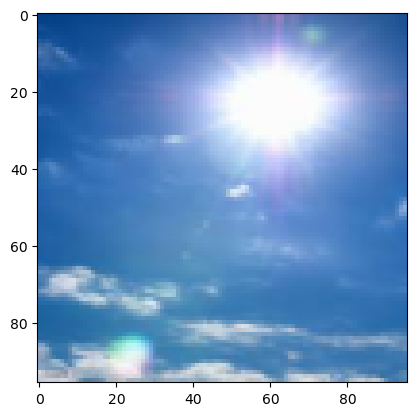

In [112]:
plt.imshow(im)
labels[0]

In [7]:
from torch import nn


In [52]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(2,2)
        self.fcl1 = nn.Linear(64*10*10,1024)
        self.fcl2 = nn.Linear(1024,4)
    def forward(self,x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1,64*10*10)
#         print(x.size())
        x = torch.relu(self.fcl1(x))
        x = self.fcl2(x)
        return x
model = Net()
pred = model(imgs)
torch.argmax(pred,1)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [53]:
if torch.cuda.is_available():
    model.to('cuda')

In [114]:
loss_fn = nn.CrossEntropyLoss()

In [115]:
optim = torch.optim.Adam(model.parameters(),lr=0.001)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [56]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    #告诉模型dropout是在训练模式
#     model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_loss += loss.item()
    train_loss /= num_batches
    correct /= size
    return train_loss, correct

In [57]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    #告诉模型dropout是在预测模式
#     model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    return test_loss, correct

In [58]:
epochs  = 30
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(train_dl, model, loss_fn, optim)
    epoch_test_loss, epoch_test_acc = test(test_dl, model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    
    template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                "test_loss: {:.5f}, test_acc: {:.1f}%")
    print(template.format(
          epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    
print("Done!")

epoch: 0, train_loss: 0.64959, train_acc: 73.7% ,test_loss: 0.57094, test_acc: 75.6%
epoch: 1, train_loss: 0.41788, train_acc: 83.0% ,test_loss: 0.39112, test_acc: 84.9%
epoch: 2, train_loss: 0.33097, train_acc: 87.1% ,test_loss: 0.52347, test_acc: 80.0%


KeyboardInterrupt: 

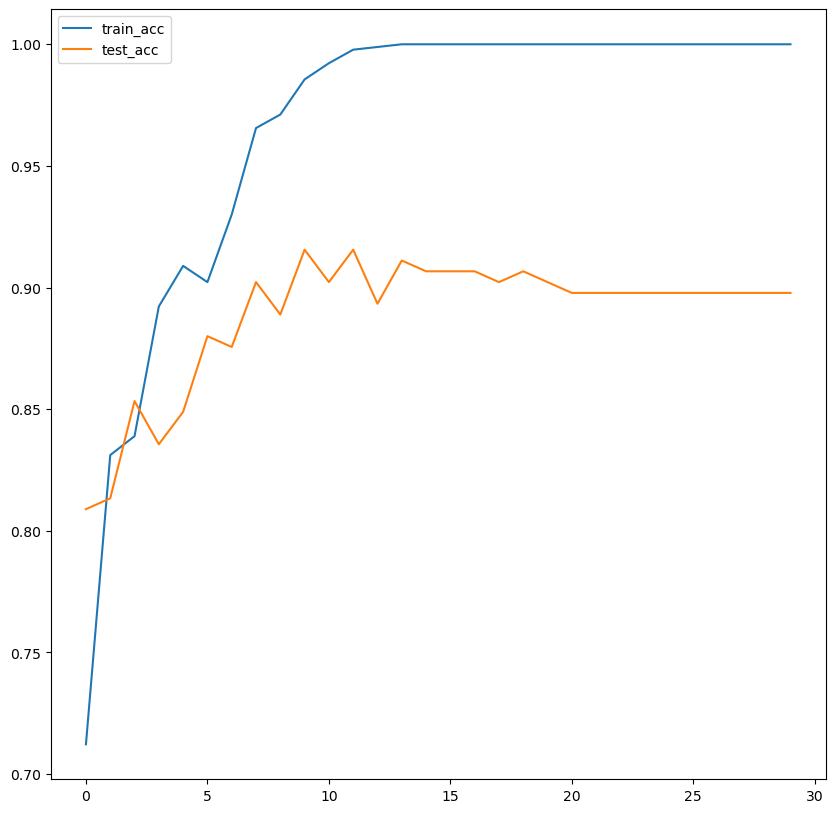

In [29]:
plt.figure(figsize=(10,10))
plt.plot(range(30),train_acc,label='train_acc')
plt.plot(range(30),test_acc,label='test_acc')
plt.legend()

### dropout 抑制过拟合

dropout 就是随机的丢弃一些神经元，相当于随机森林，创造了多棵决策树，进行投票。dropout每次创建模型都会随机选取一部分神经元不输出，机型预测的时候会将全部神经元激活（加权平均）。
1. 取平均的作用
2. 减少神经元之间复杂的共适应关系： 因为dropout程序导致两个神经元不一定每次都在一个dropout网络中出现。这样权值的更新不再依赖于有固定关系的隐含节点的共同作用，阻止了某些特征仅仅在其它特定特征下才有效果的情况 。
3. Dropout类似于性别在生物进化中的角色：物种为了生存往往会倾向于适应这种环境，环境突变则会导致物种难以做出及时反应，性别的出现可以繁衍出适应新环境的变种，有效的阻止过拟合，即避免环境改变时物种可能面临的灭绝
dropout在训练和测试的时候表现是不一样的 dropout只在训练起作用 预测时候会激活所有神经元 所以dropout也需要使用 train和eval标明训练还是预测

In [29]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        #这个float参数表示随机丢弃多少神经元 0.5就是50%
        self.drop = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2,2)
        self.fcl1 = nn.Linear(64*10*10,1024)
        self.fcl2 = nn.Linear(1024,256)
        self.fcl3 = nn.Linear(256,4)
    def forward(self,x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1,64*10*10)
#         print(x.size())
        x = torch.relu(self.fcl1(x))
        x = self.drop(x)
        x = torch.relu(self.fcl2(x))
        x = self.drop(x)
        x = self.fcl3(x)
        return x
model = Net()
model.to(device)
# 原来正确率上不来的原因是 之前的优化函数的参数=是之前咩有dropout的model参数
optim = torch.optim.Adam(model.parameters(),lr=0.001)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    #告诉模型dropout是在训练模式
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_loss += loss.item()
    train_loss /= num_batches
    correct /= size
    return train_loss, correct

In [31]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    #告诉模型dropout是在预测模式
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    return test_loss, correct

In [32]:
# model.train 和 model.eval 主要影响的是dropout层和BN层
epochs  = 30
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(train_dl, model, loss_fn, optim)
    epoch_test_loss, epoch_test_acc = test(test_dl, model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    
    template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                "test_loss: {:.5f}, test_acc: {:.1f}%")
    print(template.format(
          epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    
print("Done!")

epoch: 0, train_loss: 0.85408, train_acc: 60.8% ,test_loss: 0.53155, test_acc: 79.6%
epoch: 1, train_loss: 0.50765, train_acc: 77.9% ,test_loss: 0.42671, test_acc: 80.4%


KeyboardInterrupt: 

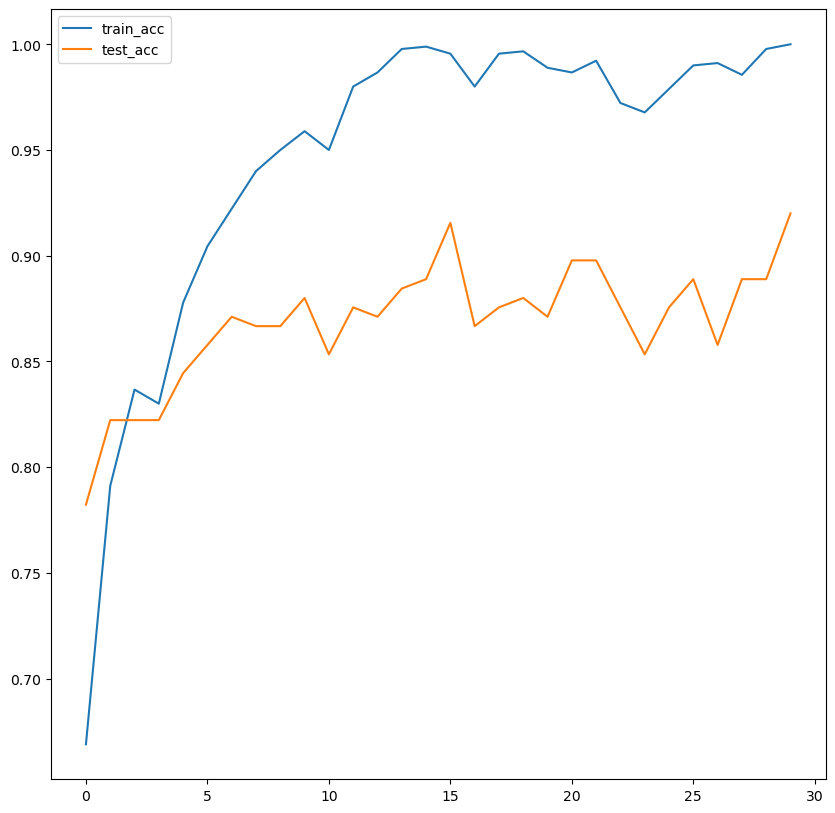

In [120]:
plt.figure(figsize=(10,10))
plt.plot(range(30),train_acc,label='train_acc')
plt.plot(range(30),test_acc,label='test_acc')
plt.legend()

## 批标准化
传统机器学习的标准化也就是i归一化，用于当几个变量的量纲差距非常大，比如红细胞数目10的6次方但是血压只有几十 这个时候要统一量纲增强模型的鲁棒性
数据标准化让机器学习模型看到的不同样本彼此之间更加相似，这有助于模型的学习与对新数据的泛化
归一化就是化成0-1 便准化就是将数据减去其平均值使其中心为 0，然后将数据除以其标准差使其标准差为 1
### **批标准化**
1. 不仅在数据输入之前那需要对数据进行标准化，在神经网络中也需要对数据进行标准化，因为第一层的时候，可能是0-1，但是i经过权重相乘，加上偏置，可能最后的输出大于1，要对每一层进行批标准化。
2. 批标准化解决的问题是梯度消失与梯度爆炸 关于梯度消失：关于梯度消失，以sigmoid函数为例子，sigmoid函数使得输出在[0,1]之间。 。如果输入很大，其对应的斜率就很小，反向传播梯度就很小，学习速率就很慢。我们知道数据预处理做标准化可以加速收敛，同理，在神经网络使用标准化也可以加速收敛，而且还有更多好处。
![](./dataset2/Snipaste_2022-11-10_16-08-00.png)
3. 具有正则化的效果 提高模型的泛化能力 允许更高的学习速率从而加速收敛

批标准化有助于梯度传播，因此允许更深的网络。对于有些特别深的网络，只有包含多个BatchNormalization 层时才能进行训练
BatchNormalization 层通常在卷积层或密集连接层之
后使用。
nn.BatchNorm1d()
nn.BatchNorm2d()
BN操作共分四步：前两部分别计算批处理的数据均值和方差，第三步则根据计算的均值、方差对该批数据进行规范化，前三步类似于数据的归一化处理 。而第四步则是关键的一步，也是其差异所在。第四步引入了一个线性函数 ，其中参数 γ 起到scale的作用， β  起到shift的作用，Z = γ*z +β这两个参数要通过训练得到。最后一步的”尺度变换和偏移“操作是为了让因训练而”刻意加入的BN能够有可能还原最初的输入，说通俗点就是，即矫正了变化了的层数据分布，同时又不影响原有层数据的表示能力。
在训练的正向传播中，不会改变当前输出，只记录下γ与β。
在反向传播的时候，根据求得的γ与β通过链式求导方式，求出学习速
率以至改变权值。
所以dropout也需要使用 train和eval标明训练还是预测



### 添加BN层

In [41]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3)
        #其实就是in_features数量
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,3)
        self.bn3 = nn.BatchNorm2d(64)
        #这个float参数表示随机丢弃多少神经元 0.5就是50%
        self.drop = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2,2)
        self.fcl1 = nn.Linear(64*10*10,1024)
        self.bn_f1 = nn.BatchNorm1d(1024)
        self.fcl2 = nn.Linear(1024,256)
        self.bn_f2 = nn.BatchNorm1d(256)
        self.fcl3 = nn.Linear(256,4)
    def forward(self,x):
        # 都在激活函数之后添加bn层
        x = torch.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.pool(x)
       #Z这个地方变成了1d 所以bn要变成1d
        x = x.view(-1,64*10*10)
#         print(x.size())
        x = torch.relu(self.fcl1(x))
        x = self.bn_f1(x)
        x = self.drop(x)
        x = torch.relu(self.fcl2(x))
        x = self.bn_f2(x)
        x = self.drop(x)
        x = self.fcl3(x)
        return x
model = Net()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
# 原来正确率上不来的原因是 之前的优化函数的参数=是之前咩有dropout的model参数
optim = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [42]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    #告诉模型dropout是在训练模式
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_loss += loss.item()
    train_loss /= num_batches
    correct /= size
    return train_loss, correct

In [43]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    #告诉模型dropout是在预测模式
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    return test_loss, correct

In [44]:
# model.train 和 model.eval 主要影响的是dropout层和BN层
epochs  = 30
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(train_dl, model, loss_fn, optim)
    epoch_test_loss, epoch_test_acc = test(test_dl, model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    
    template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                "test_loss: {:.5f}, test_acc: {:.1f}%")
    print(template.format(
          epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    
print("Done!")

epoch: 0, train_loss: 0.69402, train_acc: 71.7% ,test_loss: 0.48703, test_acc: 76.9%
epoch: 1, train_loss: 0.43494, train_acc: 85.7% ,test_loss: 0.39871, test_acc: 81.8%
epoch: 2, train_loss: 0.33231, train_acc: 88.7% ,test_loss: 0.29223, test_acc: 89.8%
epoch: 3, train_loss: 0.27715, train_acc: 90.1% ,test_loss: 0.37363, test_acc: 87.6%
epoch: 4, train_loss: 0.28440, train_acc: 90.6% ,test_loss: 0.42879, test_acc: 87.6%
epoch: 5, train_loss: 0.34877, train_acc: 89.6% ,test_loss: 0.34825, test_acc: 90.2%
epoch: 6, train_loss: 0.27344, train_acc: 90.6% ,test_loss: 0.32372, test_acc: 87.6%
epoch: 7, train_loss: 0.26926, train_acc: 91.1% ,test_loss: 0.25980, test_acc: 91.6%
epoch: 8, train_loss: 0.17754, train_acc: 93.3% ,test_loss: 0.32413, test_acc: 87.6%
epoch: 9, train_loss: 0.19812, train_acc: 93.4% ,test_loss: 0.31718, test_acc: 91.6%
epoch:10, train_loss: 0.15382, train_acc: 94.7% ,test_loss: 0.32719, test_acc: 92.0%
epoch:11, train_loss: 0.09827, train_acc: 97.2% ,test_loss: 0.218

KeyboardInterrupt: 